# Twitter Sentiment Analysis

## The Objective

This is intended for academic purposes, please note, this is a NLP Sentiment Analysis project.

WE WERE TASKED TO BY OUR SENIOR BUSINESS INTELLEGENCE MANAGEMENT TEAM TO CREATE A SENTIMENT ANALYSIS FROM TWITTER DATA

Business Interest

- Identify: THE ABILITY TO ACCURATELY CLASSIFY SENTIMENTS (POSTIVE OR NEGATIVE)


- Understand: DOES THIS INITIATIVE ADD VALUE OR GIVE MORE INSIGHTS TO THE ORGANIZATION’S BUSINESS INTEREST


- Strategize: CREATE A BUSINESS STAREGY OR DIRECTION FOR OUR TEAMS PARTNERED STAKEHOLDERS



In [1]:
#utilities
import re
import pickle
import numpy as np
import pandas as pd
#plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#nltk
import nltk
from nltk.stem import WordNetLemmatizer
#sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Importing and cleaning data

Data understanding:

We have two datasets: one provided via Data World and Kaggle. Both datasets were both differently encoded, requiring some extra paramaters to be passed into structure the datasets, prior to merging. 

- Data Structures:

Label Dataset (Kaggle)

Sentiment: built in binary target for Postive (4) and Negative (0)

IDs: the unique id of the user

Date: the date/time posted, timestamp

User: user id for the tweet 

Tweet: unstructed tweets prior to preprocessing





- Label Dataset_sm (Data World)


Tweet: unstructured tweets with hastags (#), mentions (@), and html lypterlinks (http(s):)


Brand:based on the tweets there are product types mentioned (Apple, google, and various products)


Sentiment: multiclass targets that needed to be preprocessed

In [4]:
#removing encoding and naming columns
data_columns = ['sentiment','ids','date','flag','user','tweet']
data_encoding = 'ISO-8859-1'
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding=data_encoding,names=data_columns)
dataset_columns_sm = ['tweet','brand','sentiment']
dataset_encoding_sm = 'latin1'
dataset_sm = pd.read_csv('tweet_product_company.csv', encoding = dataset_encoding_sm, names=dataset_columns_sm)

In [5]:
dataset.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset_sm.head()

,tweet,brand,sentiment
0,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_pro...
1,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
2,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
3,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
4,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion


In [7]:
x = dataset_sm[dataset_sm['sentiment'] == 'No emotion toward brand or product'].index

In [8]:
y = dataset_sm[dataset_sm['sentiment'] == "I can't tell"].index

In [9]:
z = dataset_sm[dataset_sm['sentiment'] == "is_there_an_emotion_directed_at_a_brand_or_product"].index

In [10]:
# dataset_sm.drop(x, inplace = True)
# dataset_sm.drop(y, inplace = True)
# dataset_sm.drop(z, inplace = True)

In [11]:
dataset_sm.describe

<bound method NDFrame.describe of                                                   tweet  \
1     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
2     @jessedee Know about @fludapp ? Awesome iPad/i...   
3     @swonderlin Can not wait for #iPad 2 also. The...   
4     @sxsw I hope this year's festival isn't as cra...   
5     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9078  @mention your PR guy just convinced me to swit...   
9080  &quot;papyrus...sort of like the ipad&quot; - ...   
9081  Diller says Google TV &quot;might be run over ...   
9086  I've always used Camera+ for my iPhone b/c it ...   
9089                      Ipad everywhere. #SXSW {link}   

                                brand         sentiment  
1                              iPhone  Negative emotion  
2                  iPad or iPhone App  Positive emotion  
3                                iPad  Positive emotion  
4                  iPad o

In [14]:
#Checking summary stats
dataset.describe()

,sentiment,ids
count,12800.000000,1.280000e+04
mean,2.000000,1.998755e+09
std,2.000078,1.936175e+08
min,0.000000,1.467810e+09
25%,0.000000,1.956908e+09
50%,2.000000,2.002093e+09
75%,4.000000,2.177042e+09
max,4.000000,2.329151e+09


In [13]:
#dataset = dataset.iloc[::5,:]
#dataset = dataset.iloc[::5,:]
#dataset = dataset.iloc[::5,:]

In [15]:
#checking the binary classes of our target variable
dataset.sentiment.value_counts()

4    6400
0    6400
Name: sentiment, dtype: int64

In [16]:
#removing undesired columns
dataset = dataset[['sentiment','tweet']]
#replacing 4 with 1 for easier understanding
dataset['sentiment'] = dataset['sentiment'].replace(4,1)


In [17]:
# This for tagging the tweets 

import spacy 
from spacy import displacy

In [18]:
nlp = spacy.load('en_core_web_lg')

In [19]:
#text = dataset['text'].str.cat(sep=' ')

dataset = dataset.set_index(np.arange(0,12800))

In [20]:
#function used for tagging the tweets

def explain_text_entities(dataset_column):
    tag_list = []
    noun_list = []
    for index, value in dataset_column.items():
        value_tags = []
        nouns = []
        doc = nlp(value)
        for ent in doc.ents:
            value_tags.append(ent.label_)
        for chunk in doc.noun_chunks:
            nouns.append([chunk.root.text, chunk.root.dep_])
        tag_list.append(value_tags)
        noun_list.append(nouns)
    dataset['tags'] = tag_list
    dataset['nouns'] = noun_list
    

In [21]:
# Isolating columns to process tweets

dataset_1 = dataset['tweet']
#dataset_1 = dataset_1[:5]
explain_text_entities(dataset_1)

In [22]:
# Sanity checking the data

dataset.head()

,sentiment,tweet,tags,nouns
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",[PERSON],"[[http://twitpic.com/2y1zl, ROOT], [bummer, at..."
1,0,@allyheman but.. but.. but.. I'm not a big fan...,[],"[[@allyheman, ROOT], [I, nsubj], [fan, attr], ..."
2,0,New video card is DOA.,[ORG],"[[card, nsubj], [DOA, attr]]"
3,0,"STOU site not update, no info about 2/2552 exa...",[ORG],"[[site, nsubj], [info, dobj], [exam, pobj], [c..."
4,0,@Anistorm Sorry,[],[]


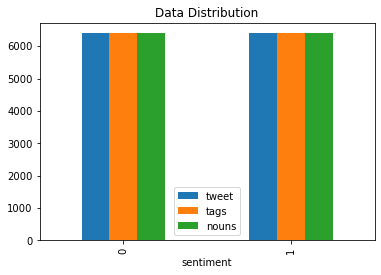

In [23]:
ax = dataset.groupby('sentiment').count().plot(kind='bar',title='Data Distribution')


The above distributions shows the spread of tweets, tags, and nouns by sentiment

# Merging the two Datasets

In [24]:
full_dataset = pd.concat([dataset,dataset_sm], axis = 0)

In [25]:
# Processing the binary classes for our combined dataset

full_dataset['sentiment'] = dataset['sentiment'].replace('Positive emotion',1)
full_dataset['sentiment'] = dataset['sentiment'].replace('Negative emotion',0)
full_dataset

,sentiment,tweet,tags,nouns,brand
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",[PERSON],"[[http://twitpic.com/2y1zl, ROOT], [bummer, at...",NaN
1,0,@allyheman but.. but.. but.. I'm not a big fan...,[],"[[@allyheman, ROOT], [I, nsubj], [fan, attr], ...",NaN
2,0,New video card is DOA.,[ORG],"[[card, nsubj], [DOA, attr]]",NaN
3,0,"STOU site not update, no info about 2/2552 exa...",[ORG],"[[site, nsubj], [info, dobj], [exam, pobj], [c...",NaN
4,0,@Anistorm Sorry,[],[],NaN
...,...,...,...,...,...
9078,1,@mention your PR guy just convinced me to swit...,NaN,NaN,iPhone
9080,1,&quot;papyrus...sort of like the ipad&quot; - ...,NaN,NaN,iPad
9081,1,Diller says Google TV &quot;might be run over ...,NaN,NaN,Other Google product or service
9086,1,I've always used Camera+ for my iPhone b/c it ...,NaN,NaN,iPad or iPhone App


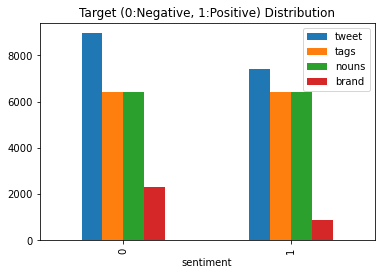

In [68]:
dist_target = full_dataset.groupby('sentiment').count().plot(kind='bar',title='Target (0:Negative, 1:Positive) Distribution')

In [26]:
#Sanity check the length of the combined dataset
len(full_dataset)

16348

In [27]:
#seperating text and sentiment into itterable list
text, sentiment = list(full_dataset['tweet']),list(full_dataset['sentiment'])            

In [28]:
#replacing emojis with text equivelent
emojis = {':)':'smile',':-)':'smile',':d':'wink',':-E':'vampire',':(':'sad',':-(': 'sad', ':-<': 'sad',
          ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


#creating more robust stopwords list
stop_word_list = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


After creating paramaters for stop words and emojis, below is a ReGex and Lemmatization function to pre process the tweets

In [35]:
def preprocess(textdata):
    #empty list to return after processing is done
    processed_text = []
    
    #instance of lemmatizer
    word_lemmatizer = WordNetLemmatizer()
    
    #regex patterns
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_numeric_pattern = '[^a-zA-Z0-9]'
    repeating_character_pattern = r'(.)\1\1+'
    replace_repeat_char = 'r\1\1'
    
    #looping through eacg tweet
    for tweet in textdata:
        
        #making the tweet lower case
        tweet = tweet.lower()
        
        #replacing all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, 'EMOJI'+emojis[emoji])
        
        #replacing all urls
        tweet = re.sub(url_pattern, 'URL',tweet)
        
        #replacing all usernames
        tweet = re.sub(user_pattern, 'USER',tweet)
        
        #replacing all non alphanumeric values
        tweet = re.sub(alpha_numeric_pattern, ' ', tweet)
        
        #replace all repeating characters
        tweet  = re.sub(repeating_character_pattern, replace_repeat_char, tweet)
        
        tweet_words = ''
        for word in tweet.split():
            if word not in stop_word_list:
                if word != 'USER':
                    if word != 'URL':
                        if len(word)>1:
                            word = word_lemmatizer.lemmatize(word)
                            tweet_words += (word+' ')
        processed_text.append(tweet_words)
    return processed_text

In [37]:
# This is a counter and timer to visually see how long the data will take to prcoess all the tweets

import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken:{round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken:2 seconds


In [43]:
processedtext_positive = preprocess(positive_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken:{round(time.time()-t)} seconds')
processedtext_negative = preprocess(negative_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken:{round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken:343 seconds
Text Preprocessing complete.
Time Taken:345 seconds


In [44]:
# Another preprocessing of negative and postive sentiments

negative =  full_dataset.loc[(full_dataset['sentiment'] == 0)]
positive = full_dataset.loc[(full_dataset['sentiment'] == 1)]
positive_text,negative_text = list(positive['tweet']),list(negative['tweet'])

# Word Clouds

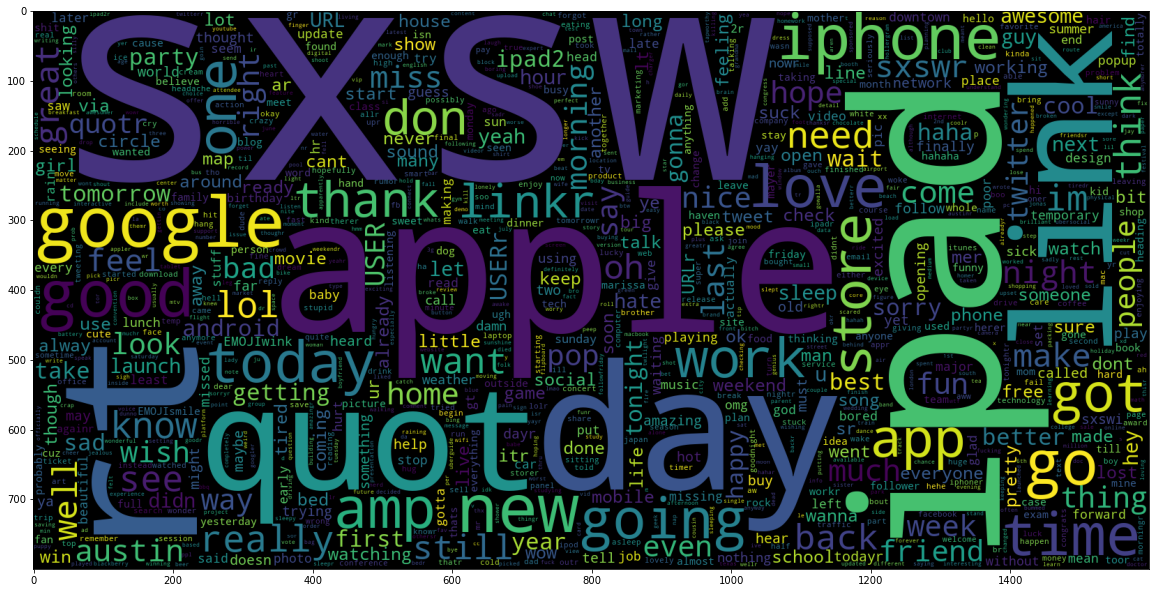

In [75]:
# Visualizing via wordcloud to show the most used words
data = processedtext[:16348]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data))
plt.imshow(wc)

plt.savefig('overall_wordcloud.png')

Per the word cloud we are are to see that Apple, iPad, SXSW, and Google are some of the most talked about entities. This shows a spread of various topics, brands, and events.

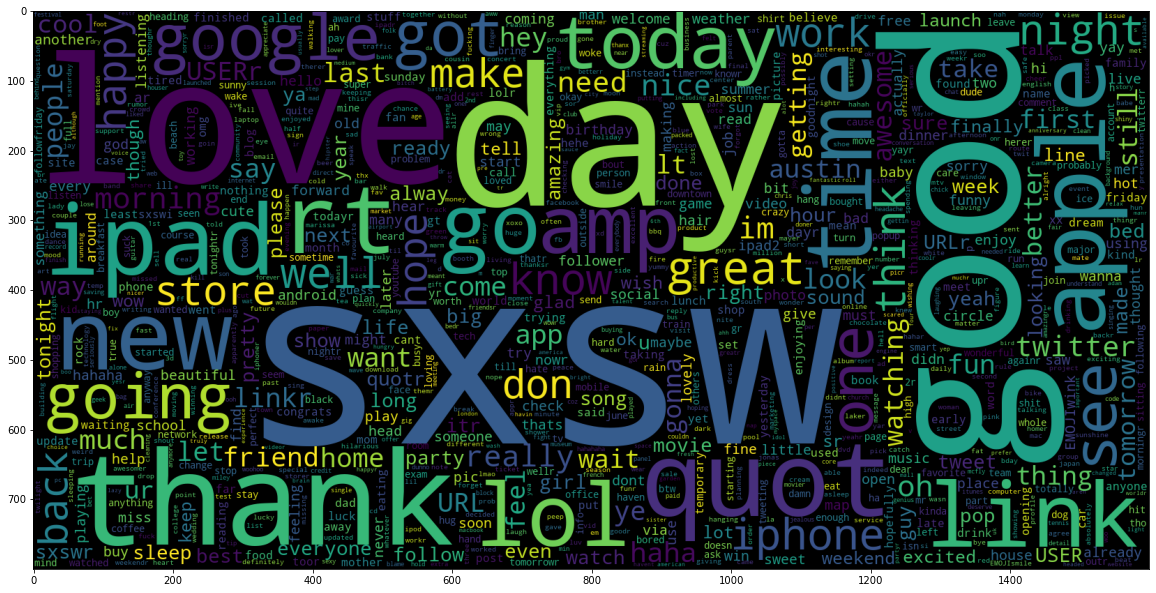

In [76]:
#positive word cloud
data_positive = processedtext_positive[:7395]
plt.figure(figsize = (20,20))
wc_positive = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_positive))
plt.imshow(wc_positive)

plt.savefig('pos_wordcloud.png')

In this is the most talked about positive topics. In this word cloud we are see: good, day, SXSW, and love--just to name a few. The dataset shows a huge emphasis on SXSW, siting that there are large postive sentiments regarding SXSW. 

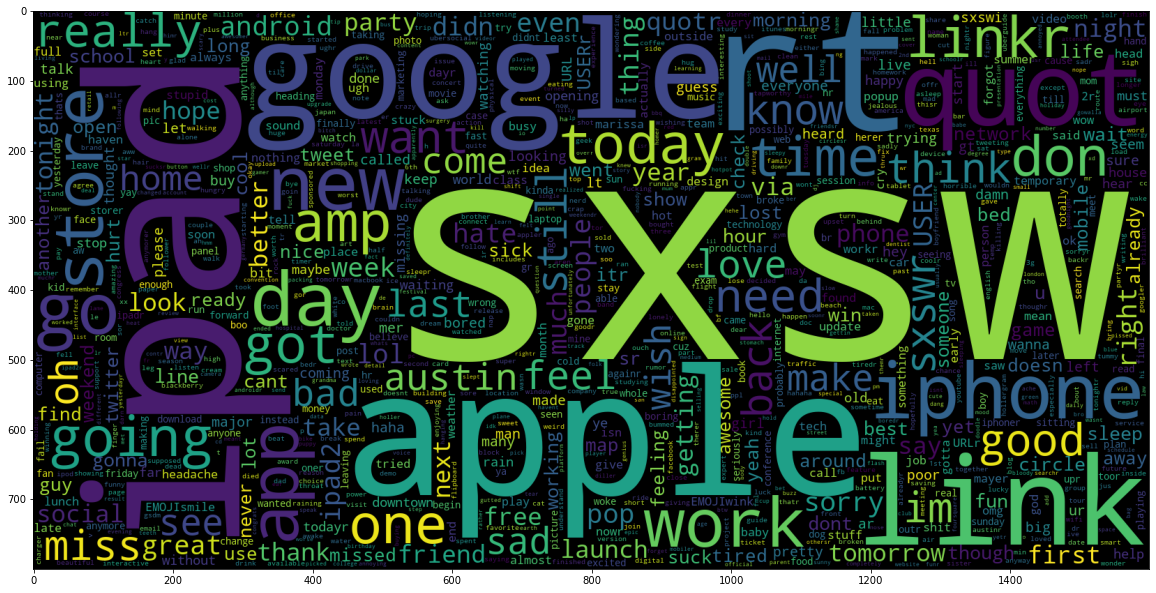

In [77]:
#negative wordcloud

data_negative = processedtext_negative[:8953]
plt.figure(figsize = (20,20))
wc_negative = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_negative))
plt.imshow(wc_negative)

plt.savefig('neg_wordcloud.png')

The word cloud above shows the negative sentiment spread within our dataset. We're seeing now an emphasis on products: Google, iPad, Apple, iphone, and work. However, we see SXSW, this could be due to it having similar mentions in both postive and negative. Also, SXSW being an event--mixed sentiments will always be distributed.

# Model Preprocessing and Train-Test-Split

In [48]:
#Train Test Split

X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [49]:
# TFIDF vectorizer

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  20000


In [50]:
## TFID tranformation to our X variable in train and testing set

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [51]:
# function created to make model evals more efficient

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Baseline Modeling

### Bernoulli Naive Bayes 

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      1741
           1       0.64      0.78      0.70      1529

    accuracy                           0.69      3270
   macro avg       0.70      0.70      0.69      3270
weighted avg       0.71      0.69      0.69      3270



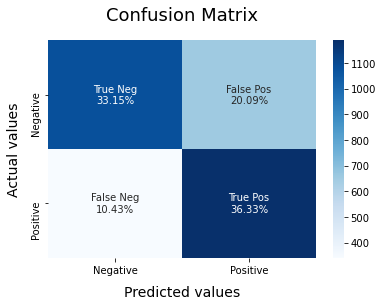

In [52]:
# Instanciating model and fitting

BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

In regard to our standard metric (accuracy) our model is hitting 69%

For this first iteration our basline vanilla model is showing a good performance.

### Support Vector Classifer

              precision    recall  f1-score   support

           0       0.72      0.82      0.76      1741
           1       0.75      0.63      0.69      1529

    accuracy                           0.73      3270
   macro avg       0.73      0.72      0.73      3270
weighted avg       0.73      0.73      0.73      3270



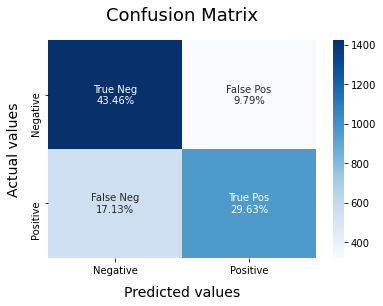

In [54]:
from sklearn.svm import SVC

SVCmodel = SVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Using the Support Vector Classifier our accuracy has raised to 73% untuned. However, our tur-postives has decreaded and we an increase in false negatives.

Let's also apply another baseline vanilla model.

### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(random_state=0)
rand_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1741
           1       0.72      0.63      0.67      1529

    accuracy                           0.71      3270
   macro avg       0.71      0.70      0.70      3270
weighted avg       0.71      0.71      0.71      3270



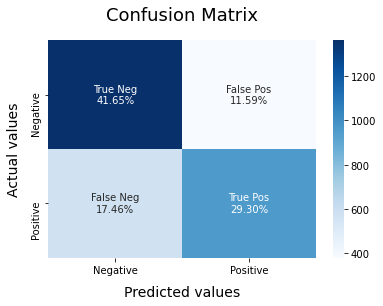

In [56]:
model_Evaluate(rand_forest)

With Random Forest we are seeing decreases in accuray (71%). Also, decreses in True Negatives and increase in False postives--as a result of decreases in general accuracy.

## Hyperparamater Tuning of Vanilla Models

The two models we have decided to tune will be SVC and Logistic Regression Classifer. We will apply Gridsearch CV, that will perform 5-fold cross-val and also give us the best params for our tuned models. 

In [57]:
from sklearn.model_selection import KFold,RepeatedStratifiedKFold,GridSearchCV,cross_val_score

### Logistic Regression Classifier, with GridSearch CV

In [60]:
## Setting up para for SVC with GridSearch CV

param_grid_Log = {'C':[1.0,10.0,100.0,1000.0],'max_iter':[1,10,100,1000], 'solver':['lbfgs','liblinear','sag','saga'], 'penalty':['l1','l2','elasticnet']}

grid_Log = GridSearchCV(estimator = LogisticRegression(),
                        param_grid=param_grid_Log,
                        scoring='accuracy',
                        verbose=1,
                        n_jobs=-1
                        )

result_grid_Log = grid_Log.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 715 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 953 out of 960 | elapsed: 34.3min remaining:   15.1s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 63.6min finished
/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [61]:
result_grid_Log.best_params_

{'C': 1.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}

In [62]:
LRmodel = LogisticRegression(C = 1, max_iter = 10, n_jobs=-1, solver='saga',penalty='l2')
LRmodel.fit(X_train, y_train)


/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=1, max_iter=10, n_jobs=-1, solver='saga')

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1741
           1       0.75      0.65      0.69      1529

    accuracy                           0.73      3270
   macro avg       0.73      0.73      0.73      3270
weighted avg       0.73      0.73      0.73      3270



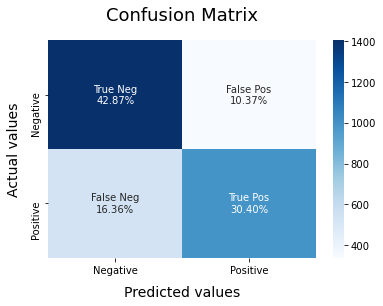

In [63]:
model_Evaluate(LRmodel)

We applied logistic regression with GridSearch CV to test a basic model with hyperparmater tuning. Although, we see a 73% accuracy score, there is an increase in True Postives and True Negatives. Moreover, there is a reduction in our False Negatives. 

This model is performing optimally, but we do want to do a comparision of SVC to a tuned version--as we are anticipating a better performance increase. 

### SVC, with GridSearch CV

In [64]:
from sklearn.model_selection import KFold,RepeatedStratifiedKFold,GridSearchCV,cross_val_score


In [65]:
from sklearn.svm import SVC

svc = SVC(random_state=0)
svc.fit(X_train, y_train)

SVC(random_state=0)

In [67]:
param_grid_SVC = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

grid_SVC = GridSearchCV(estimator=SVC(),
                    param_grid=param_grid_SVC,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

result_grid_SVC = grid_SVC.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 55.1min finished


In [69]:
result_grid_SVC.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [70]:

SVC_tuned = SVC()
SVC_tuned = SVC(gamma=1, C=1, kernel='rbf')
SVC_tuned.fit(X_train, y_train)



              precision    recall  f1-score   support

           0       0.72      0.82      0.76      1741
           1       0.75      0.63      0.69      1529

    accuracy                           0.73      3270
   macro avg       0.73      0.72      0.73      3270
weighted avg       0.73      0.73      0.73      3270



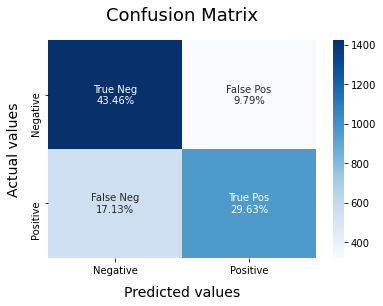

In [71]:
model_Evaluate(SVC_tuned)

At this point we are seeing much more favorable results with the tuned SVC model as we have a 74% accuracy. Although we a reduction in the true Negative compared to our initial SVC un-tune dmodel, we see an increase in Tue postive to 31%.

In terms of recall, our model is showing 80% in dentifying False Negatives, capturing a better population of negative comments. 

# SWOT Analysis

## Strength 

1) The strength of our full dataset, shows a better distribution of classes both in our independent variables and our taget class (sentiments). We are also mindful that there is a small class imbalance where the majority class (negative) is up by almost 13%. However, as a team we discussed that the 13& imbalance should not play a huge factor. But we will potentially explore apply resampling methods in our second iteration of this sentiment analysis.

2) Being able to classify negative sentiments more accurately. Allowing us to address these negative subjects (products, events, and references/topics) more efficeintly. Which, in turn, will help stakeholders create actionable insights. WE want to stress the importance that postive sentiments are a good indicator of customer/audiance statisfaction, but in terms of of retention or devloping a new customer base--we it is imperative to understand the shortcoming (negative).


## Weaknesses

1) The supplemental dataset from Kaggle, lacked product tags and required manual classification. Unlike our initial dataset that had seperation of tags (product) and a detailed target sentiment. The challenege for this portion of the initiative was to ensure we had the correct classification, a balanced data set, and ensuring our pre-processing was not missguided. However, we were able to over come those challeges by continual sanity checking and through visualization we were able to matain a serile data preparation process. 

2) Our classification continously failed to classify postive sentiments at the same rate as the negative comments. This could be due to again the 13% class imbalnce of our target variable--but that the time we choose to move forward in the modeling process to build out a diversity of models (un-tuned and tuned). We will keep this in mind moving towards version 2.0 of this analysis to test if applications of respanding measure will show a higher accuray in classifying postive sentiments. Note, in this iniial version of the project, we wanted to being able to identify negative sentiments to better address the needs of our stakeholders.


## Opportunities, with respect to our Stakeholders

1) Marketing Team
- This will help in creating a targeted campaining per the ability to pinpoint what customers want to see improve. 
- Go to market strategy, emphasising product improvements to the new resleases/updates, new developed products, and increase investor relations.

2) Business Intelligence and Analysics Teams
- Since this is version 1.0 of the sentiment analysis initiative--we would like to further request for additional tenical assets optimize our cureent data (large formatting data engineering and building out a realtional data base). 

3) Product Development
- With this analysis the organization's product development team can create a strategy to enhance the current product offering. 
- The development of new products given from our analysis to better gain new customers


## Threats, internal and external--no one was harmed in the process

Internal

1) This model focuses on the negative meaning that marketing may have difficulty emphasizing strengths. The model didn't fully implement tagging so seperating by subject matter will be difficult. This would draw bias towards on the negative sentiments, which could be considered a "negativity" focused marketing campain. We are also aware that there needs to be increases in model improvement to better classify postive sentiments. In regard to a two sided approach within marketing's campaning stategy. 

External

2) With more time we would be able to develop and. refine positive sentiment and make it separable by topic as well as classifying neutral sentiment. Since version 1.0 was focused on sentiment analysis in respects to our target (negative or postive), we need to have a focus on a multi-class classifier to truly indentify a larger variety of topics. The threat to this project could also be sited in need more time, human capital, and computing power--compition from other organication/firms with a higher capacity of the abovementioned could make all the efforts of version one obsolete.

# Next Steps

## Versioning

If management approves of this initiave for version 2.0, we would like to have a extending deadline, possible for all of Q2. Further we would like to work with the devloper PMs (project management) and QA (quality assurance) teams to ensure that we have version controls set in place. Also we would like the developers input in terms of pre-delopyments for any enhancements and furtehr requiremnts prior to working with QA for UAT (user acceptance testing).  

## Resources

As mentioned abe the threat to this project is both time and resources (human capital and hardware capabilities). If given the budget we would like to recuit (or contract) the following: data engineer, technical business analyst, and data analyst (or technical consultant). By having a more enhanced team and boots on the group we can ensure that during Q2 we can have a few sprints to provide enhancements and optimizations prior/during UAT. In regard to hardware capabilities, we will need more computing power and sever space for real time updates and analysis, both for the business intelligence dashboards and machnie learning model(s) enhancements.

## User Interface

Creating an internal user interface for future analysis will be advantageous to all internal stakeholders. This will help be useful to the product development team in better understanding the customer journey and what our audiance wants in future products (or updates). Marketing will be able to also map the customer journey and sentiment for future campaigns. Sales/Strategy team to help guide them for future go-to-market startegy.